# arXiv Usage Summary

# Section 1: Data Loading

Here we collect the data related to the daily usage of arXiv through the number of connections to the arXiv.org site on a particular day. It seems that arXiv was not tracking daily usage before Jan 1, 2024 (or, at least, it's not accessible via that API).  Hence, our data series will start on that date.

/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[0]` which will be converted to string and not roundtrip correctly.
  impl.write(


<Axes: xlabel='0'>

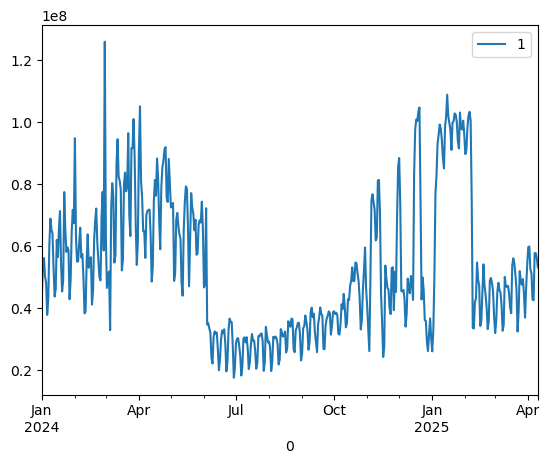

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Load data
arxiv_totals = pd.read_parquet("../../data/arxiv-totals.parquet")

import time

usage_list = []

for index in arxiv_totals[arxiv_totals.index >= pd.Timestamp(2024, 1, 1)].index:
    day_usage_stats = pd.read_csv(
        "https://arxiv.org/stats/get_hourly?date=" + str(index.strftime("%Y%m%d"))
    )
    usage_list.append(tuple([index, day_usage_stats.node1.sum()]))

    # arXiv allows 1 request every 3 seconds, for our use here it means that it will take about 20 minutes
    time.sleep(3)

usage = pd.DataFrame(usage_list).set_index(0)

usage.to_parquet("../../data/arxiv-usage.parquet")

usage.plot()

# Section 2: Usage Analysis

Here, we analyze the data about usage to see whether usage depends on the day of the week.  If the data shows such seasonality, we should take that into account when making posting recommendations.  Note that the usage is measured as number of connections per day: while this is not an exact measure of audience size, it is still the only reasonable proxy we can find at the moment.

We create a new column in usage containing the day of the week for each entry.

In [8]:
print(usage.head())


   index          0         1
0      0 2024-01-01  43626111
1      1 2024-01-02  54640750
2      2 2024-01-03  56101036
3      3 2024-01-04  50084378
4      4 2024-01-05  48182775


In [10]:
from calendar import day_name
import pandas as pd

# Rename columns to meaningful names
usage.rename(columns={0: "date", 1: "connections"}, inplace=True)

# Convert date column to datetime if not already
usage["date"] = pd.to_datetime(usage["date"])

# Add a new column for weekday names
usage["weekday"] = usage["date"].apply(lambda date: day_name[date.weekday()])

usage

,index,date,connections,weekday
0,0,2024-01-01,43626111,Monday
1,1,2024-01-02,54640750,Tuesday
2,2,2024-01-03,56101036,Wednesday
3,3,2024-01-04,50084378,Thursday
4,4,2024-01-05,48182775,Friday
...,...,...,...,...
461,461,2025-04-06,42500085,Sunday
462,462,2025-04-07,57708551,Monday
463,463,2025-04-08,57728496,Tuesday
464,464,2025-04-09,56104215,Wednesday


We start with a violin plot of the training dataset, split by day of the week.

<Axes: xlabel='weekday', ylabel='connections'>

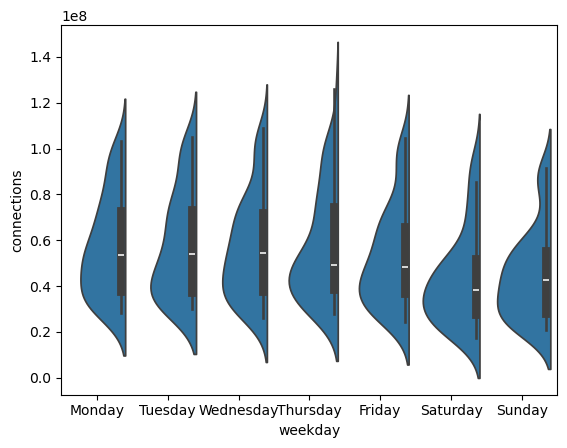

In [11]:
sns.violinplot(
    data=usage,
    x="weekday",
    y="connections",
    # hue=True,
    # hue_order=[True, False],
    split=True,
)

It does not look like the date of the week matters much for the number of connections, possibly except for weekends.  Preprints are made public ("announced") on weekdays only, so it seems reasonable to restrict the dataset to weekdays.

<Axes: xlabel='weekday', ylabel='connections'>

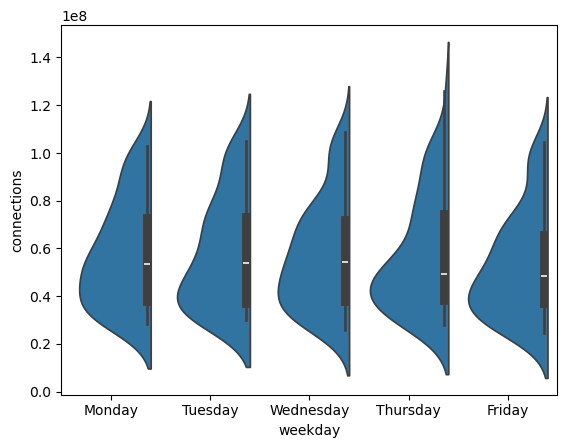

In [12]:
usage_weekdays = usage[(usage.weekday != "Saturday") & (usage.weekday != "Sunday")]
sns.violinplot(
    data=usage_weekdays,
    x="weekday",
    y="connections",
    # hue=True,
    # hue_order=[True, False],
    split=True,
)

# Section 3: Weekday Effect Hypothesis Test

We now do hypothesis testing:
- _null hypothesis_: there is no contribution from the day of the week, so the model is average plus noise,
- _alternative hypothesis_: the day of the week has a contribution, so the model is linear regression on 5 one-hot encoded variables.

First, we produce the one-hot encoding of the `weekday` feature.

In [14]:
one_hot = (
    pd.get_dummies(usage_weekdays.weekday, dtype=int)
    .drop("Friday", axis=1)
    .iloc[:, [0, 2, 3, 1]]
)
usage_weekdays = usage_weekdays.join(one_hot)

Then we use `statsmodels` to compare the model with no feature with the model regressed on `Monday`, `Tuesday`, `Wednesday`, and `Thursday`, by computing the F-test p-value.

In [30]:
import statsmodels.formula.api as smf

data = {
    "C": usage_weekdays.connections,
    "M": usage_weekdays.Monday,
    "Tu": usage_weekdays.Tuesday,
    "W": usage_weekdays.Wednesday,
    "Th": usage_weekdays.Thursday,
}

reduced_model = smf.ols("C ~ 1", data=data).fit()
full_model = smf.ols("C ~ M + Tu + W + Th", data=data).fit()

f_test = full_model.compare_f_test(reduced_model)
print("F-test p-value:", f_test[1])

F-test p-value: 0.7064791000262229


Since p = 0.706 is much greater than 0.05, you fail to reject the null hypothesis.

So, there's no strong evidence that usage on arXiv depends on the day of the week.
This justifies ignoring weekday effects when modeling usage — except perhaps for minor weekend drops you might observe visually.

Hence, if the usage data was generated by a normal probability distribution centered at the average number of connections ($C = C_0 + \varepsilon$), we would see this much improvement when we fit $C = M + Tu + W + Th + \varepsilon$ instead about $70.6 \%$ of the time.  This is not at all a rare thing to happen, so evidence is supporting the independence of the number of connections on the day of the week.

In [17]:
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      C   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 15 Jun 2025   Prob (F-statistic):                nan
Time:                        12:55:21   Log-Likelihood:                -6126.2
No. Observations:                 334   AIC:                         1.225e+04
Df Residuals:                     333   BIC:                         1.226e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.661e+07   1.23e+06     46.185      0.000    5.42e+07     5.9e+07
==============================================================================
Omnibus:                       28.294   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.649
Skew:                           0.647   Prob(JB):                     9.91e-07
Kurtosis:                       2.441   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that the number of connections seems to depend on some other seasonal feature, but if we limit our forecasting to the week then they don't appear to be relevant.

<Axes: xlabel='Date', ylabel='Connections'>

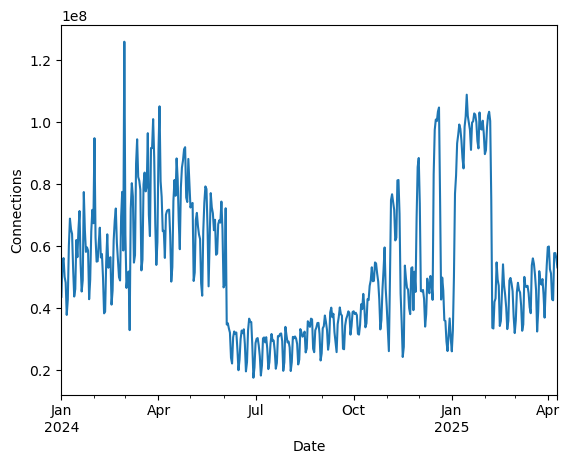

In [18]:
pd.read_parquet("../../data/arxiv-usage.parquet").plot(
    xlabel="Date", ylabel="Connections", legend=False
)

# Section 4: Correlation with Posting Activity

Here we extract the total number of article appearances on each day by summing the rows of arxiv-totals.

In [22]:
# Create daily totals (row sums)
totals = pd.read_parquet("../../data/arxiv-totals.parquet")

# Ensure the index is in datetime format (if not already)
totals.index = pd.to_datetime(totals.index)

# Filter the DataFrame from 2024-01-01 onwards
totals_recent = totals.loc[totals.index >= "2024-01-01"]

# Sum across columns (i.e., across all categories) for each row (i.e., each date)
totals_sum = totals_recent.sum(axis=1)

# Convert the resulting Series into a DataFrame with a meaningful column name
totals_sum_df = totals_sum.to_frame(name="total_appearances")

totals_sum_df



,total_appearances
date,
2024-01-01,591.0
2024-01-02,825.0
2024-01-03,1002.0
2024-01-04,1060.0
2024-01-05,928.0
...,...
2025-04-06,628.0
2025-04-07,1636.0
2025-04-08,1560.0


We verify if there is a correlation between the total appearances and the number of connections on a given day. 

In [28]:
from scipy.stats import pearsonr

# Flatten to 1D if needed
x = totals_sum_df["total_appearances"].values.flatten()
y = usage.values.flatten()

# Compute Pearson correlation
r, p_value = pearsonr(x, y)

# Print result
print(f"Correlation: {float(r):.4f}, p-value: {float(p_value):.4e}")


Correlation: 0.2482, p-value: 5.7026e-08


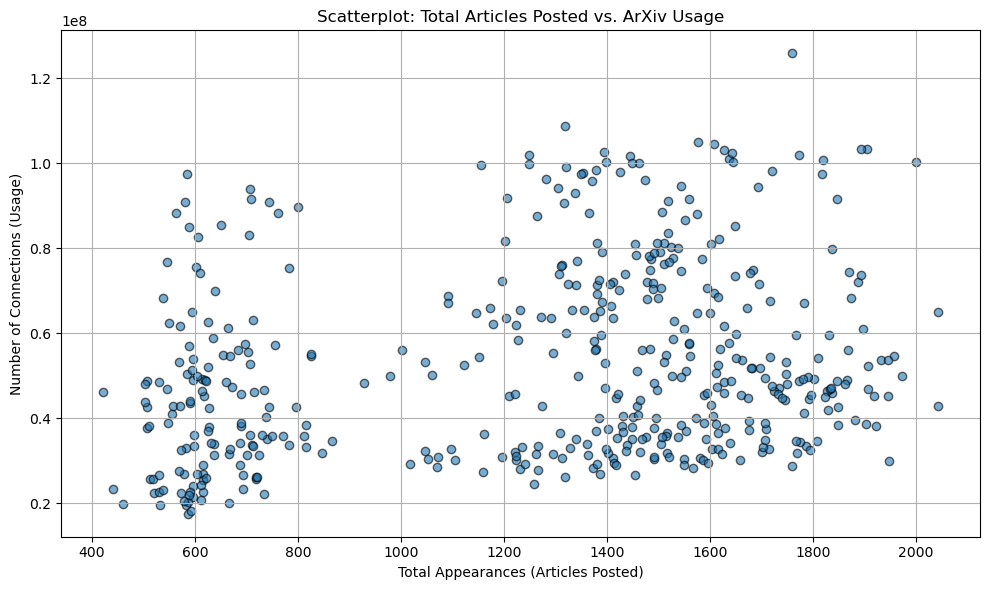

In [25]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Create the scatterplot
plt.scatter(combined["total_appearances"], combined[1], alpha=0.6, edgecolor='k')

# Add labels and title
plt.xlabel("Total Appearances (Articles Posted)")
plt.ylabel("Number of Connections (Usage)")
plt.title("Scatterplot: Total Articles Posted vs. ArXiv Usage")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Section 5: Conclusion

Key Findings:
- Usage is relatively stable across weekdays, with no statistically significant weekday effect (p > 0.05).
- There is a statistically significant but modest correlation (r = 0.2482, p ≈ 5.7e-08) between daily arXiv usage and total article postings.

This suggests that while usage is not heavily seasonal, it may weakly reflect submission volumes, and can be cautiously used in forecasting or recommendation systems.
